In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import platform
from tqdm import tqdm 
from pathlib import Path
from rasterio.warp import transform
from pyproj import Transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dask.diagnostics import ProgressBar
from ascat.read_native.ragged_array_ts import CellFileCollection
from ascat.cell import CellGridFiles

import geopandas as gpd
from shapely.geometry import Polygon, MultiPoint


## Map Sentinel-1 and ASCAT

In [2]:
def process_sentinel_and_ascat(sentinel_path, output_path, sentinel_crs):
    """
    Load Sentinel-1 Zarr file, assign EPSG, collocate with ASCAT data, and save to NetCDF.
    
    Parameters:
        zarr_path (str or Path): Path to Sentinel-1 Zarr file
        sentinel_epsg (str): EPSG code for Sentinel-1 data (e.g., "EPSG:27704")
        output_path (str): Path to save the resulting NetCDF file
    """
    print("Loading Sentinel-1 data...")
    sentinel_ds = xr.open_zarr(sentinel_path)
    sentinel_ds = sentinel_ds.rio.write_crs(sentinel_crs)
    sentinel_ds_latlon = sentinel_ds.rio.reproject("EPSG:4326")
    var = sentinel_ds_latlon['VV'].isel(time=-1)
    valid_mask = ~np.isnan(var.values)
    
    lats = sentinel_ds_latlon['y'].values
    lons = sentinel_ds_latlon['x'].values
    lon2d, lat2d = np.meshgrid(lons, lats)
    valid_points = np.column_stack([lon2d[valid_mask], lat2d[valid_mask]])
    gdf_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(valid_points[:,0], valid_points[:,1]), crs="EPSG:4326")
    tile_polygon = gdf_points.geometry.union_all().convex_hull  # creating a polygon for selecting the ascat points
    print("Done")

    print("Loading ASCAT data...")
    paths = yaml.safe_load(Path("../paths.yml").read_text())
    system_key = "windows" if platform.system() == "Windows" else "linux"
    root = Path(paths[system_key]).expanduser()
    cell_source = root / "datasets/scat_ard/ascat_ssm_cdr_12.5km_h121"
    assert cell_source.exists(), f"ASCAT data path does not exist: {cell_source}"

    h121_reader = CellGridFiles.from_product_id(cell_source, "H121")
    ascat_ds = h121_reader.read(geom = tile_polygon)
    print("Done")

    print("Processing...")
    points_ds = ascat_ds.cf_geom.to_point_array()
    x, y = Transformer.from_crs("EPSG:4326", sentinel_crs, always_xy=True).transform(points_ds.lon, points_ds.lat)
    points_ds['e7x'] = ('obs', x)
    points_ds['e7y'] = ('obs', y)

    ascat_sentinel = sentinel_ds.sel(
        x=points_ds.e7x.load(),
        y=points_ds.e7y.load(),
        time=points_ds.time.load(),
        method="nearest"
    )

    ascat_ds['s1-VH'] = ("obs", ascat_sentinel['VH'].data)
    ascat_ds['s1-VV'] = ("obs", ascat_sentinel['VV'].data)
    print("Done")

    print(f"Saving output to {output_path}...")
    ascat_ds['subsurface_scattering_probability'].encoding.update({'dtype': 'float32'}) # Ensure correct dtype as NANs are a problem otherwise
    with ProgressBar():
        ascat_ds.to_netcdf(output_path)
    print(f"Done! Collocated dataset saved to {output_path}")


In [ ]:
# Europe
europe_files = [d for d in os.listdir("../data/Sentinel-1/Europe") if d.endswith(".zarr")]

for d in tqdm(europe_files, desc="Processing Europe"):
    sentinel_path = os.path.join("../data/Sentinel-1/Europe", d)
    output_path = os.path.join("../data/ascat_h121_sentinel-1/Europe", 
                               "ascat_h121_" +  d.replace(".zarr", ".nc"))
    
    print(f"Processing Europe: {sentinel_path} -> {output_path}")
    process_sentinel_and_ascat(
        sentinel_path=sentinel_path,
        output_path=output_path,
        sentinel_crs="EPSG:27704"
    )

# Africa
africa_files = [d for d in os.listdir("../data/Sentinel-1/Africa") if d.endswith(".zarr")]

for d in tqdm(africa_files, desc="Processing Africa"):
    sentinel_path = os.path.join("../data/Sentinel-1/Africa", d)
    output_path = os.path.join("../data/ascat_h121_sentinel/Africa", 
                               "ascat_h121_" +  d.replace(".zarr", ".nc"))
    
    print(f"Processing Africa: {sentinel_path} -> {output_path}")
    process_sentinel_and_ascat(
        sentinel_path=sentinel_path,
        output_path=output_path,
        sentinel_crs="EPSG:27701"
    )

## Checking the Results

In [ ]:
folders = [
    "../data/ascat_h121_sentinel-1/Africa",
    "../data/ascat_h121_sentinel-1/Europe"
]

summary = []

for folder in folders:
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)

        ds = xr.open_dataset(filepath)

        sizes = ds.sizes
        n_obs = sizes.get("obs", None)
        n_locations = sizes.get("locations", None)

        time_values = pd.to_datetime(ds["time"].values)

        n_timesteps = len(time_values)
        first_time = time_values[0]
        last_time = time_values[-1]

        month_periods = pd.Series(time_values).dt.to_period("M")
        month_counts = month_periods.value_counts()
        min_obs_per_month = month_counts.min() if not month_counts.empty else 0
        months_covered = month_counts.size

        summary.append([
            filepath, n_locations, n_obs, n_timesteps,
            first_time, last_time,
            min_obs_per_month, months_covered
        ])

df_summary = pd.DataFrame(summary, columns=[
    "path", "n_locations", "n_obs", "n_timesteps", "first_time", "last_time",
    "min_obs_per_month", "months_covered"
])

print(df_summary.to_string(index=False))

                                                         path  n_locations    n_obs  n_timesteps                    first_time                     last_time  min_obs_per_month  months_covered
../data/ascat_h121_sentinel-1/Africa/ascat_h121_E033N090T3.nc          311  4690330      4690330 2007-01-02 09:22:50.478000128 2024-12-31 20:53:03.255000064              10064             216
../data/ascat_h121_sentinel-1/Africa/ascat_h121_E036N090T3.nc          450  6893094      6893094 2007-01-02 09:22:41.136000000 2024-12-31 19:55:39.770999808              14642             216
../data/ascat_h121_sentinel-1/Africa/ascat_h121_E030N090T3.nc          451  6784063      6784063 2007-01-01 21:02:08.408000000 2024-12-31 21:35:45.136999936              14360             216
../data/ascat_h121_sentinel-1/Africa/ascat_h121_E036N087T3.nc          642  9549903      9549903 2007-01-02 09:23:23.599999488 2024-12-31 19:55:06.648000000              20427             216
../data/ascat_h121_sentinel-1/Africa/asc

In [38]:
ds = xr.open_dataset("../data/ascat_h121_sentinel-1/Europe/test_E033N012T3.nc")
ds

<xarray.Dataset> Size: 649MB
Dimensions:                            (obs: 9267488, locations: 557)
Coordinates:
    time                               (obs) datetime64[ns] 74MB ...
    lon                                (locations) float32 2kB ...
    lat                                (locations) float32 2kB ...
    alt                                (locations) float32 2kB ...
Dimensions without coordinates: obs, locations
Data variables: (12/23)
    as_des_pass                        (obs) int8 9MB ...
    swath_indicator                    (obs) int8 9MB ...
    surface_flag                       (obs) uint8 9MB ...
    surface_soil_moisture              (obs) float32 37MB ...
    surface_soil_moisture_noise        (obs) float32 37MB ...
    backscatter40                      (obs) float32 37MB ...
    ...                                 ...
    sat_id                             (obs) int8 9MB ...
    row_size                           (locations) int64 4kB ...
    location_id                        (locations) int64 4kB ...
    location_description               (locations) <U1 2kB ...
    s1-VH                              (obs) float32 37MB ...
    s1-VV                              (obs) float32 37MB ...
Attributes:
    id:                 1250.nc
    date_created:       2025-01-09 12:32:26
    featureType:        timeSeries
    grid_mapping_name:  fibgrid_12.5

### Check Timeseries

In [ ]:
# Select one location
loc_id = ds['location_id'].values[0]

subset = ds.where(ds['location_id'] == loc_id, drop=True)
subset

<xarray.Dataset> Size: 890MB
Dimensions:                            (obs: 9267488, locations: 1)
Coordinates:
    time                               (obs) datetime64[ns] 74MB ...
    lon                                (locations) float32 4B -6.174
    lat                                (locations) float32 4B 40.13
    alt                                (locations) float32 4B 9.969e+36
Dimensions without coordinates: obs, locations
Data variables: (12/23)
    as_des_pass                        (obs, locations) float32 37MB 0.0 ... 0.0
    swath_indicator                    (obs, locations) float32 37MB 0.0 ... 1.0
    surface_flag                       (obs, locations) float32 37MB 0.0 ... 1.0
    surface_soil_moisture              (obs, locations) float32 37MB 68.86 .....
    surface_soil_moisture_noise        (obs, locations) float32 37MB 3.36 ......
    backscatter40                      (obs, locations) float32 37MB -10.37 ....
    ...                                 ...
    sat_id                             (obs, locations) float32 37MB 3.0 ... 4.0
    row_size                           (locations) float64 8B 1.596e+04
    location_id                        (locations) float64 8B 1.059e+06
    location_description               (locations) object 8B ''
    s1-VH                              (obs, locations) float32 37MB nan ... ...
    s1-VV                              (obs, locations) float32 37MB nan ... ...
Attributes:
    id:                 1250.nc
    date_created:       2025-01-09 12:32:26
    featureType:        timeSeries
    grid_mapping_name:  fibgrid_12.5

/home/jwagner/miniconda3/envs/ascat-s1-synergy/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


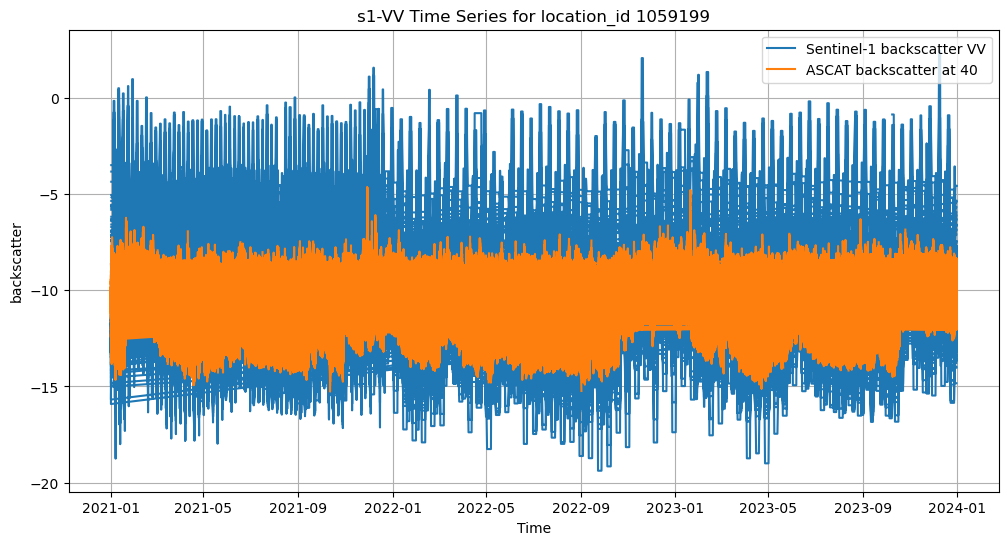

In [ ]:
time_index = pd.to_datetime(subset['time'].values)

mask = (time_index >= '2021-01-01') & (time_index <= '2023-12-31')

filtered_time = time_index[mask]
filtered_s1_VV = subset['s1-VV'].values[mask]
filtered_backscatter40 = subset['backscatter40'].values[mask]

plt.figure(figsize=(12,6))
plt.plot(filtered_time, filtered_s1_VV, label='Sentinel-1 backscatter VV')
plt.plot(filtered_time, filtered_backscatter40, label='ASCAT backscatter at 40')
plt.xlabel('Time')
plt.ylabel('backscatter')
plt.title(f's1-VV Time Series for location_id {loc_id}')
plt.legend()
plt.grid(True)
plt.show()

loading two files simutaniously:

https://github.com/TUW-GEO/ascat/blob/master/src/ascat/cell.py#L341
    def _merge_contiguous(self, data):


### Check alignment ASCAT points on Sentinel tiles

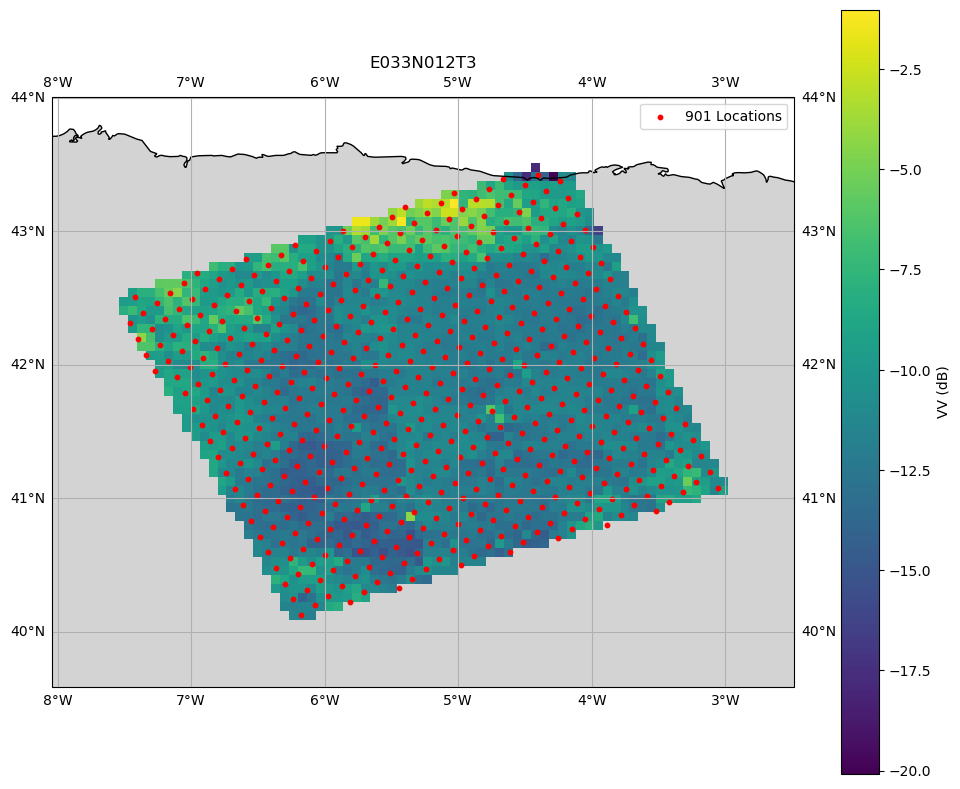

In [41]:
zarr_ds = xr.open_zarr('../data/Sentinel-1/Europe/E033N012T3.zarr')
vv = zarr_ds['VV'].isel(time=10)
vv_latlon = vv.rio.reproject("EPSG:4326")

lons = ds['lon'].values
lats = ds['lat'].values

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

buffer = 0.5
ax.set_extent([
    vv_latlon.rio.bounds()[0] - buffer, vv_latlon.rio.bounds()[2] + buffer,
    vv_latlon.rio.bounds()[1] - buffer, vv_latlon.rio.bounds()[3] + buffer
], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True)

img = vv_latlon.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False)
ax.scatter(lons, lats, color='red', s=10, label='901 Locations', transform=ccrs.PlateCarree())
plt.colorbar(img, ax=ax, label='VV (dB)')
plt.title("E033N012T3")
plt.legend()
plt.tight_layout()
plt.show()


## Testing the Workflow

In [ ]:
# testing the function

sentinel_path = "../data/Sentinel-1/Europe/E033N012T3.zarr"
output_path = "../data/ascat_h121_sentinel-1/Europe/test_E033N012T3.nc"
sentinel_crs = "EPSG:27704"

# ----------------------------------------------------

print("Loading Sentinel-1 data...")
sentinel_ds = xr.open_zarr(sentinel_path)
sentinel_ds = sentinel_ds.rio.write_crs(sentinel_crs)

sentinel_ds_latlon = sentinel_ds.rio.reproject("EPSG:4326")

# bbox:
# latmin = float(sentinel_ds_latlon.y.min())
# latmax = float(sentinel_ds_latlon.y.max())
# lonmin = float(sentinel_ds_latlon.x.min())
# lonmax = float(sentinel_ds_latlon.x.max())
# bbox = (latmin, latmax, lonmin, lonmax)

# polygon:
var = sentinel_ds_latlon['VV'].isel(time=-1)
valid_mask = ~np.isnan(var.values)

lats = sentinel_ds_latlon['y'].values
lons = sentinel_ds_latlon['x'].values
lon2d, lat2d = np.meshgrid(lons, lats)
valid_points = np.column_stack([lon2d[valid_mask], lat2d[valid_mask]])
gdf_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(valid_points[:,0], valid_points[:,1]), crs="EPSG:4326")
tile_polygon = gdf_points.geometry.union_all().convex_hull
print("Done")

print("Loading ASCAT data...")
paths = yaml.safe_load(Path("../paths.yml").read_text())
system_key = "windows" if platform.system() == "Windows" else "linux"
root = Path(paths[system_key]).expanduser()
cell_source = root / "datasets/scat_ard/ascat_ssm_cdr_12.5km_h121"
assert cell_source.exists(), f"ASCAT data path does not exist: {cell_source}"

h121_reader = CellGridFiles.from_product_id(cell_source, "H121")
ascat_ds = h121_reader.read(geom = tile_polygon)
print("Done")

print("Processing...")
points_ds = ascat_ds.cf_geom.to_point_array()
x, y = Transformer.from_crs("EPSG:4326", sentinel_crs, always_xy=True).transform(points_ds.lon, points_ds.lat)
points_ds['e7x'] = ('obs', x)
points_ds['e7y'] = ('obs', y)

ascat_sentinel = sentinel_ds.sel(
    x=points_ds.e7x.load(),
    y=points_ds.e7y.load(),
    time=points_ds.time.load(),
    method="nearest"
)

ascat_ds['s1-VH'] = ("obs", ascat_sentinel['VH'].data)
ascat_ds['s1-VV'] = ("obs", ascat_sentinel['VV'].data)
print("Done")

print(f"Saving output to {output_path}...")
ascat_ds['subsurface_scattering_probability'].encoding.update({'dtype': 'float32'}) # Ensure correct dtype as NANs are a problem otherwise
with ProgressBar():
    ascat_ds.to_netcdf(output_path)
print(f"Done! Collocated dataset saved to {output_path}")